In [1]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner
import os
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

_XSERVTransSocketUNIXCreateListener: ...SocketCreateListener() failed
_XSERVTransMakeAllCOTSServerListeners: server already running
(EE) 
Fatal server error:
(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) 


In [2]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (2.0, 1.0)), n=(32, 16),
                            cell_type=mesh.CellType.triangle,)
V = fem.FunctionSpace(msh, ("Lagrange", 1))

In [3]:
facets = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 2.0)))

In [4]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

In [5]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [6]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

In [7]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [8]:
with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



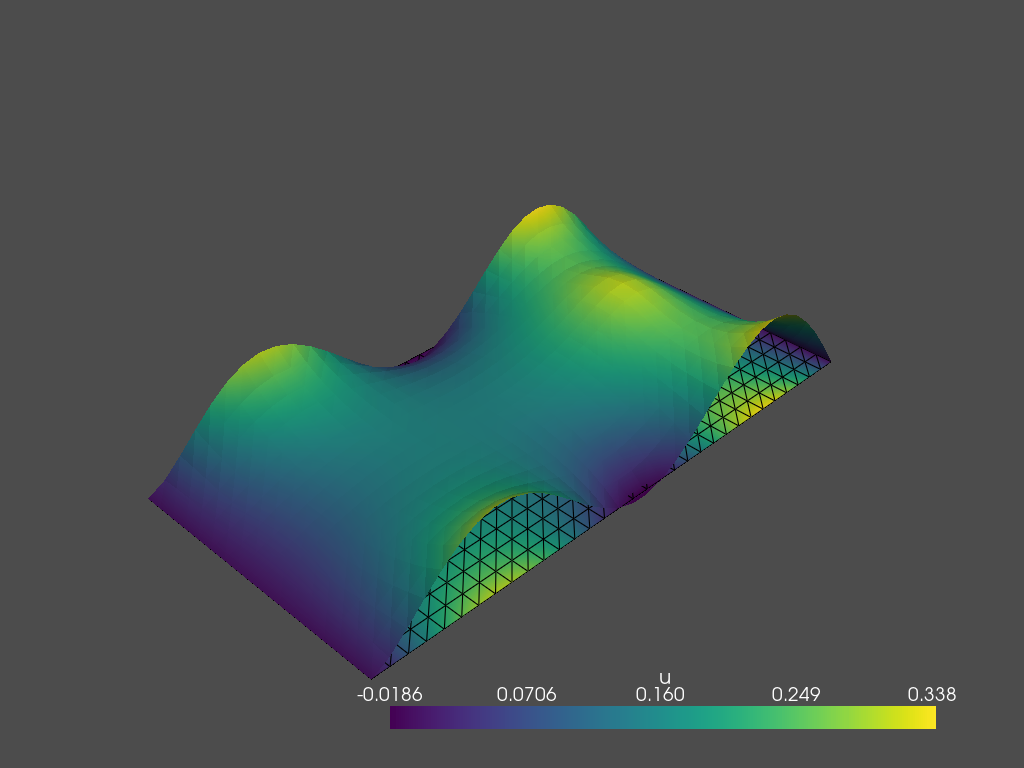

In [9]:
try:
    import pyvista
    cells, types, x = plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()

except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")